# Dilated Causal Convolutional Neural Network for sequence modeling

This can servce as an introduction to modern day transformer networks like GPT. Here we have a dataset of most common first names of people in USA. We want to build a model that generates new names based on the names in dataset. This based on the paper [van den Oord et al 2016](https://arxiv.org/pdf/1609.03499).

# Part 1: Loading and Creating Dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Open the dataset and view the first 10 words in the dataset
words = open('names.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:10])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Create a mapping from characters to position and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Part 2: Building and Training the Model

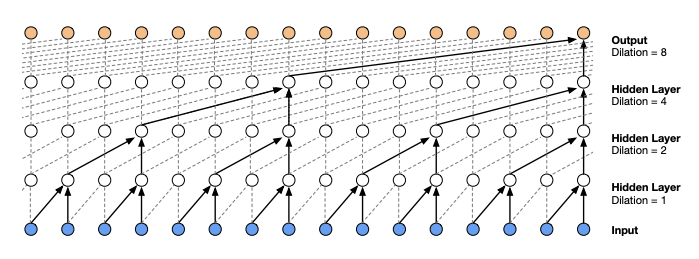

In [4]:
# Shuffling the dataset
import random
random.seed(42)
random.shuffle(words)

In [5]:
# Building the dataset with context length
block_size = 8 # character context for next character prediction, so last 3 character is used to predict next character

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size # Initially context start with [0,0,0] which is [...]
    for ch in w + '.': # . is the ending character for each word
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Rolling - the first character of context is removed and the next character is added from word [...]->[..e]
  X = torch.tensor(X) # context for train [[...], [..e], [.em]], obviously X contains pos not characters
  Y = torch.tensor(Y) # next character pred [e, m, m], obviously Y contains pos not characters
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # Train split - 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # Dev/Val split - 10%
Xte, Yte = build_dataset(words[n2:]) # Test split - 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
# Linear class which defines incoming  and outgoing connections and creates weights and biases on it
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    # fan_in is the input connections and fan_out is the total number of neurons
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Use this if no batch norm
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [7]:
# Batch Norm class which defines the gamma and beta parameters based on dimensions which is generally preceding linear layer fanout dim, we also track running mean and std so that
# it can be used during inference. While training batch mean and std is used for batch normalization of weight of previous linear layer
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim) # alpha we mentioned above for batch norm
    self.beta = torch.zeros(dim) # beta we mentioned above for batch norm
    # Buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training: # Bit of departure from pytorch official implementation where it expects inputs as (N,C) or (N,C,L), while our implementation is (N,L,C)
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # Batch mean
      xvar = x.var(dim , keepdim=True) # Batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad(): # exponential moving average
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [8]:
# Tanh class which defines non linearity function, this has no parameters, just application of non linearity on activations
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [9]:
# Embedding class which defines the embeddings of dataset vocabulary
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim)) # vocab_size by embedding dimensions

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

In [10]:
# FlattenConsecutive class flattens the tensor where first dimension is maintained, next dimension is made a new batch and last dimesion is flattened
class FlattenConsecutive: # Bit of departure from pytorch official implementation of Flatten, so named differently
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

In [11]:
# Sequential class takes in list of layers and calls them sequentially
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [12]:
torch.manual_seed(42) # For reporducibility

In [13]:
# Lets create the model layers using the classes defined above
n_embed = 24
n_hidden = 128

model = Sequential([
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # Initialize last layer to be less confident

# Getting all the parameters of the model
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

# Make all parameters trainable
for p in parameters:
  p.requires_grad = True

76579


In [14]:
 # Training and Optimization
max_steps = 200000
batch_size = 32
lossi = [] # Stores the loss after every step

for i in range(max_steps):

  # Construct a minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # Calculate the loss

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0: # Print every once every 10k steps
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8805
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


# Part 3: Model Evaluation and Inference

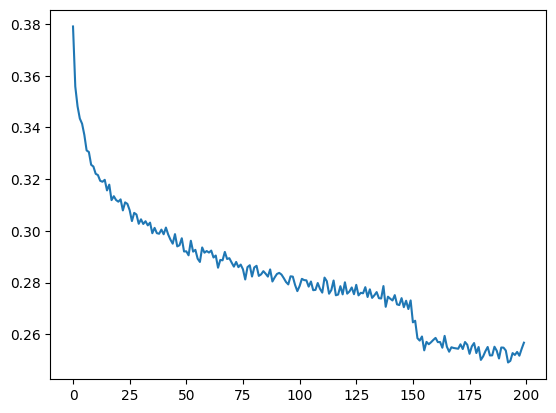

In [15]:
# Plot loss
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # Every 1000 datapoint is average to one and plotted

In [16]:
# Put model in eval mode
for layer in model.layers:
  layer.training = False

In [17]:
# Calculate loss for different split after tarining
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y) # BTW, negative log likelihood of softmax is cross entropy
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.7690284252166748
val 1.9936527013778687
test 1.9853107929229736


Performace Log

*   MLP with context length 3 and one hidden layer 200
    * Train: 2.0583250522613525
    * Val: 2.1065292358398438
    * Test: 2.104624032974243
*   MLP with context length 8 and one hidden layer 200
    * Train: 1.9163435697555542
    * Val: 2.034247875213623
    * Test: 2.0262327194213867
*   CNN with context length 8 and 3 hidden layer 68
    * Train: 1.911011815071106
    * Val: 2.020193338394165
    * Test: 2.0188705921173096
*   CNN with context length 8 and 3 hidden layer 68
    * Train: 1.7690284252166748
    * Val: 1.9936527013778687
    * Test: 1.9853107929229736



In [18]:
# Make predictions from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

aiyanah.
giusopf.
lorron.
roger.
rhyitte.
christell.
jedmccee.
kelipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jeniyah.
glatipe.
manaswi.
yeslee.
stephania.
